# Scalable Machine Learning HW2
## Javier Palomares

#### Problem 1: Convolutions
1. Compute the output of a 1D convolution layer if the input is a single-channel vector [1,-1,3,4,4]
and the kernal is [1,1] for stride =1 and padding =0.

In [24]:
vector = [1,-1,3,4,4]
kernel = [1,1]
stride = 1
padding = 0

In [25]:
# helper method to pad vectors
def pad_vector(v,padding):
    l = len(v)
    new_dim = l + 2*padding
    vec = [0] * new_dim
    vec[padding:padding+l] = v
    return vec

# helper method to compute the convolution
def convolve(vector,kernel,stride):
    import numpy as np
    index = 0
    # length of vector
    l = len(vector)
    # length of kerner
    kl = len(kernel)
    conv = [0] * (l - kl + 1)
    i = 0
    while (index < l-stride):
        v = vector[index:index+kl]
        conv[i] = np.dot(v,kernel)
        index = index + stride
        i = i + 1
    return conv

In [26]:
convolve(pad_vector(vector,padding),kernel,stride)

[0, 2, 7, 8]

2. Compute the output of a 1D convolution layer if the input is a single-channel vector [1,-1,3,4,4]
and the kernal is [1,-1] for stride =1 and padding =1 (padding one means on both sides)

In [4]:
vector = [1,-1,3,4,4]
kernel = [1,1]
stride = 1
padding = 1
convolve(pad_vector(vector,padding),kernel,stride)

[1, 0, 2, 7, 8, 4]

3. Write pytorch code that computes these outputs. Create the corresponding tensors and use
torch.nn.Conv1d and ConvTranspose1d.

In [26]:
import torch
import torch.nn as nn
vector = [1,-1,3,4,4]
kernel = [1,1]
t = torch.Tensor([[[1,-1,3,4,4]]])
conv = nn.Conv1d(in_channels=1,out_channels=1,kernel_size=2,stride=1,padding=0,bias=False)
conv.weight.data = torch.ones(1,1,2)
y=conv(t)
y

tensor([[[0., 2., 7., 8.]]], grad_fn=<SqueezeBackward1>)

In [27]:
import torch
import torch.nn as nn
vector = [1,-1,3,4,4]
kernel = [1,1]
t = torch.Tensor([[[1,-1,3,4,4]]])
conv = nn.Conv1d(in_channels=1,out_channels=1,kernel_size=2,stride=1,padding=1,bias=False)
conv.weight.data = torch.ones(1,1,2)
y=conv(t)
y

tensor([[[1., 0., 2., 7., 8., 4.]]], grad_fn=<SqueezeBackward1>)

### Problem 2: Training a CIFAR-10 CNN classifer

In this problem we will follow a tutorial to build a Convolutional neural network that classifies
images from the CIFAR-10 dataset and then modify it.

1. Start by implementing and running this tutorial. https://www.stefanfiott.com/machine-learning/cifar-10-classifier-using-cnn-in-pytorch/ Show the accuracy you get and also the
confusion matrix you obtain for the 10 classes.

CIFAR-10
The CIFAR-10 data set is composed of 60,000 32x32 colour images, 6,000 images per class, so 10 categories in total. The training set is made up of 50,000 images, while the remaining 10,000 make up the testing set.

The categories are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck.

In [27]:
import torch
import torchvision
import torchvision.transforms as transforms

In [28]:
# This is the two-step process used to prepare the
# data for use with the convolutional neural network.

# First step is to convert Python Image Library (PIL) format
# to PyTorch tensors.

# Second step is used to normalize the data by specifying a 
# mean and standard deviation for each of the three channels.
# This will convert the data from [0,1] to [-1,1]

# Normalization of data should help speed up conversion and
# reduce the chance of vanishing gradients with certain 
# activation functions.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True,
                                        download=True, 
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=4,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=True, 
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=4,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Using the trainloader we will now get a random batch of 4 training images and plot them to see what CIFAR-10 images look like.

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

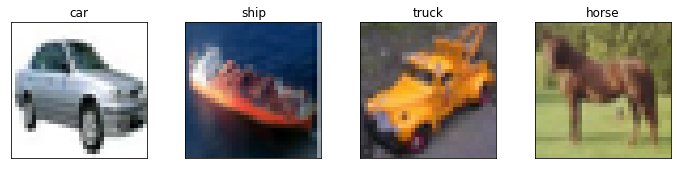

In [30]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

#### Defining the Convolutional Neural Network
Layer Dimensions
Input Size
The images are 3x32x32, i.e., 3 channels (red, green, blue) each of size 32x32 pixels.

First Convolutional Layer
The first convolutional layer expects 3 input channels and will convolve 6 filters each of size 3x5x5. Since padding is set to 0 and stride is set to 1, the output size is 6x28x28, because 
(
32
−
5
)
+
1
=
28
. This layer therefore has 
(
(
5
×
5
×
3
)
+
1
)
×
6
=
456
 parameters.

First Max-Pooling Layer
The first down-sampling layer uses max pooling with a 2x2 kernel and stride set to 2. This effectively drops the size from 6x28x28 to 6x14x14.

Second Convolutional Layer
The second convolutional layers expects 6 input channels and will convolve 16 filters each of size 6x5x5. Since padding is set to 0 and stride is set to 1, the output size is 16x10x10, because 
(
14
−
5
)
+
1
=
10
. This layer therefore has 
(
(
5
×
5
×
6
)
+
1
)
×
16
=
2416
 parameters.

Second Max-Pooling Layer
The second down-sampling layer uses max pooling with a 2x2 kernel and stride set to 2. This effectively drops the size from 16x10x10 to 16x5x5.

First Fully-Connected Layer
The output from the final max pooling layer needs to be flattened so that we can connect it to a fully connected layer. This is achieved using the torch.Tensor.view method. By specifying -1 the method will automatically infer the number of rows required. This is done to handle the mini-batch size of data.

The fully-connected layer uses ReLU for activation and has 120 nodes, thus in total it needs 
(
(
16
×
5
×
5
)
+
1
)
×
120
=
48120
 parameters.

Second Fully-Connected Layer
The output from the first fully-connected layer is connected to another fully connected layer with 84 nodes, using ReLU as an activation function. This layer thus needs 
(
120
+
1
)
×
84
=
10164
 parameters.

Output Layer
The last fully-connected layer uses softmax and is made up of ten nodes, one for each category in CIFAR-10. This layer requires 
(
84
+
1
)
×
10
=
850
 parameters.

Total Network Parameters
This convolutional neural network has a total of 
456
+
2416
+
48120
+
10164
+
850
=
62006
 parameters.

In [31]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

#### Defining the Loss Function and Optimizer
Since we are classifying images into more than two classes we will use cross-entropy as a loss function. To optimize the network we will employ stochastic gradient descent (SGD) with momentum to help get us over local minima and saddle points in the loss function space.


In [32]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#### Training the Network
We will now train the network using the trainloader data, by going over all the training data in batches of 4 images, and repeating the whole process 2 times, i.e., 2 epochs. Every 2000 batches we report on training progress by printing the current epoch and batch number along with the running loss value.

Once training is complete, we will save the model parameters to disk. This will make it possible to load the model parameters from disk the next time we run this notebook and thus not have to train the model again, saving some time.

In [33]:
import os

model_directory_path = './model/'
model_path = model_directory_path + 'cifar-10-cnn-model.pt'

if not os.path.exists(model_directory_path):
    os.makedirs(model_directory_path)

if os.path.isfile(model_path):
    # load trained model parameters from disk
    net.load_state_dict(torch.load(model_path))
    print('Loaded model parameters from disk.')
else:
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    print('Finished Training.')
    torch.save(net.state_dict(), model_path)
    print('Saved model parameters to disk.')

Loaded model parameters from disk.


#### Testing the Network
Now that the network is trained we can evaluate how it performs on the testing data set. Let us load four random images from the testing data set and their corresponding labels.

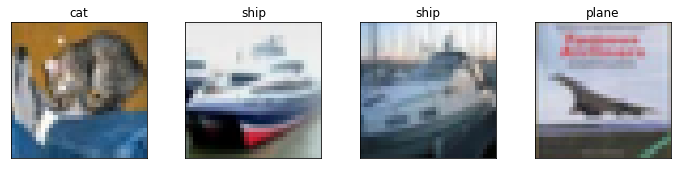

In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

Next, we input the four images to the trained network to get class (label/category) predictions.

In [9]:
outputs = net(images)

The network outputs a 2D tensor (array) of size 4x10, a row for each image and a column for each category. The values are raw outputs from the linear transformation 
$y=xA^T+b$. The category predicted for each image (row) is thus the column index containing the maximum value in that row.

In [10]:
outputs

tensor([[ 0.0814, -1.0313,  0.1324,  1.6268, -1.0405,  1.4920, -0.5321,  0.1193,
          1.1703, -0.8127],
        [ 6.4250,  7.4903, -1.1478, -4.8682, -4.0141, -6.6786, -5.5872, -4.1999,
          7.6590,  5.1888],
        [ 2.6594,  3.4164, -1.3975, -1.6951, -3.0255, -3.2068, -2.8390, -1.9887,
          4.0607,  3.8383],
        [ 4.5211,  2.1350,  0.2246, -2.2300, -1.2561, -4.1714, -3.2491, -2.5702,
          5.9149,  1.9628]], grad_fn=<AddmmBackward>)

If we prefer to get a probability score, we can use the nn.Softmax function on the raw output as follows.

In [11]:
sm = nn.Softmax(dim=1)
sm_outputs = sm(outputs)
print(sm_outputs)

tensor([[6.0773e-02, 1.9974e-02, 6.3952e-02, 2.8500e-01, 1.9792e-02, 2.4906e-01,
         3.2906e-02, 6.3121e-02, 1.8056e-01, 2.4854e-02],
        [1.3110e-01, 3.8041e-01, 6.7418e-05, 1.6331e-06, 3.8367e-06, 2.6717e-07,
         7.9576e-07, 3.1861e-06, 4.5034e-01, 3.8082e-02],
        [9.5296e-02, 2.0316e-01, 1.6489e-03, 1.2245e-03, 3.2373e-04, 2.7005e-04,
         3.9010e-04, 9.1290e-04, 3.8697e-01, 3.0980e-01],
        [1.9161e-01, 1.7626e-02, 2.6090e-03, 2.2411e-04, 5.9348e-04, 3.2159e-05,
         8.0884e-05, 1.5948e-04, 7.7223e-01, 1.4838e-02]],
       grad_fn=<SoftmaxBackward>)


#### Predicted Category for Four Test Images

In [12]:
probs, index = torch.max(sm_outputs, dim=1)

for p, i in zip(probs, index):
    print('{0} - {1:.4f}'.format(classes[i], p))

cat - 0.2850
ship - 0.4503
ship - 0.3870
ship - 0.7722


The model got one of the four testing images correct. It correctly categorised the cat and 2 ship images, but misclassified the plane as a ship
### Predicting the Category for all Test Images

In [10]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 10000 test images: 54.46%


The model performed much better than random guessing, which would give us an accuracy of 10% since there are ten categories in CIFAR-10. Let us now use the confusion matrix to compute the accuracy of the model per category.

In [15]:
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

Category   - Accuracy
plane      - 46.7
car        - 67.7
bird       - 56.6
cat        - 21.7
deer       - 27.9
dog        - 53.1
frog       - 49.6
horse      - 70.8
ship       - 77.9
truck      - 72.6


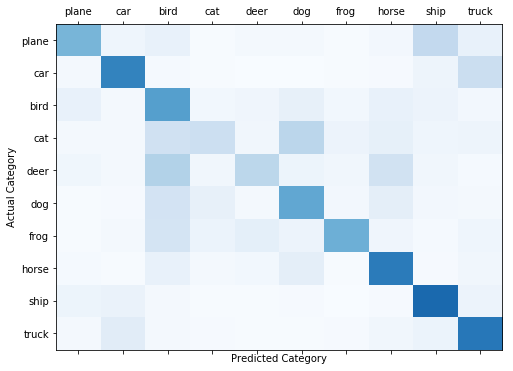

In [16]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

From the above visualisation we can see that the best accuracy was achieved on the car and ship categories, darkest shades present on the main diagonal. The truck category was most frequently confused with the car category. This is understandable, since they are both vehicles and have some visual similarities. Planes were also commonly confused with bird and ship. This could have something to do with a common background texture and colour, blue for both sky and sea.

To understand precisely which categories were most commonly confused, we can print the absolute and relative values of the confusion matrix, as follows.

In [17]:
print('actual/pred'.ljust(16), end='')
for i,c in enumerate(classes):
    print(c.ljust(10), end='')
print()
for i,r in enumerate(confusion_matrix):
    print(classes[i].ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()
    
    r = r/np.sum(r)
    print(''.ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()

actual/pred     plane     car       bird      cat       deer      dog       frog      horse     ship      truck     
plane           467       45        76        6         17        17        7         27        260       78        
                0.467     0.045     0.076     0.006     0.017     0.017     0.007     0.027     0.26      0.078     
car             20        677       13        6         1         3         6         8         47        219       
                0.02      0.677     0.013     0.006     0.001     0.003     0.006     0.008     0.047     0.219     
bird            78        23        566       28        42        81        29        71        58        24        
                0.078     0.023     0.566     0.028     0.042     0.081     0.029     0.071     0.058     0.024     
cat             18        22        196       217       34        282       55        83        44        49        
                0.018     0.022     0.196     0.217     0.034   

#### Conclusion
In this notebook, we trained a simple convolutional neural network using PyTorch on the CIFAR-10 data set. 50,000 images were used for training and 10,000 images were used to evaluate the performance. The model performed well, achieving an accuracy of 52.2% compared to a baseline of 10%, since there are 10 categories in CIFAR-10, if the model guessed randomly.

To improve the performance we can try adding convolution layers, more filters or more fully connected layers. We could also train the model for more than two epochs while introducing some form of regularisation, such as dropout or batch normalization, so as not to overfit the training data.

Keep in mind that complex models with hundreds of thousands of parameters are computationally more expensive to train and thus you should consider training such models on a GPU enabled machine to speed up the process.

2.Show the convolutional layer kernels you learned in the first convolutional layer.

In [18]:
def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()
    
def plot_filters_multi_channel(t):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    plt.show()

def plot_weights(model, layer_num, single_channel = True, collated = False):
  
  #extracting the model features at the particular layer number
  layer = model.conv1
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = model.conv1.weight.data
    
    if single_channel:
      if collated:
        plot_filters_single_channel_big(weight_tensor)
      else:
        plot_filters_single_channel(weight_tensor)
        
    else:
      if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor)
      else:
        print("Can only plot weights with three channels with single channel = False")
        
  else:
    print("Can only visualize layers which are convolutional")

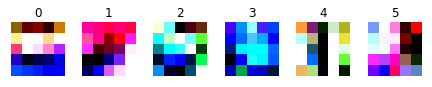

In [19]:
#visualize weights for first conv layer
plot_weights(net, 0, single_channel = False)

3.Replace the architecture with AlexNet (https://github.com/icpm/pytorch-cifar10/blob/master/models/AlexNet.py) and report accuracy. Tune hyperparameters to get the best
possible accuracy on a test set.

In [34]:
NUM_CLASSES = 10


class AlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x

In [35]:
anet = AlexNet()
model_directory_path = './alex-net-model/'
model_path = model_directory_path + 'cifar-10-cnn-model.pt'
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(anet.parameters(), lr=0.001, momentum=0.9)

if not os.path.exists(model_directory_path):
    os.makedirs(model_directory_path)

if os.path.isfile(model_path):
    # load trained model parameters from disk
    anet.load_state_dict(torch.load(model_path))
    print('Loaded model parameters from disk.')
else:
    anet.train()
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = anet(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    print('Finished Training.')
    torch.save(anet.state_dict(), model_path)
    print('Saved model parameters to disk.')


Loaded model parameters from disk.


In [36]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = anet(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 10000 test images: 52.92%


In [66]:
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

Category   - Accuracy
plane      - 77.9
car        - 77.8
bird       - 47.5
cat        - 30.4
deer       - 37.0
dog        - 22.3
frog       - 69.2
horse      - 56.3
ship       - 63.3
truck      - 47.4


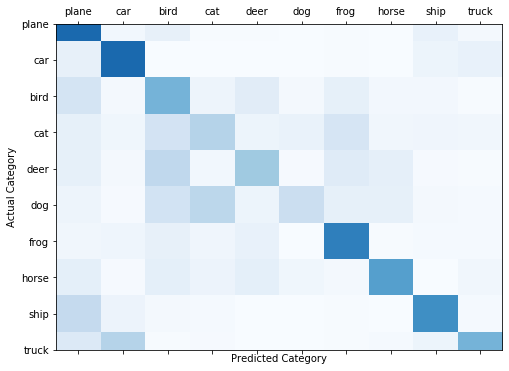

In [67]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

4.Using the first CNN you trained, build another binary classifer that classifies images as ’Plane’
or ’Not Plane’. Compute the AUC of this binary classifier. Retrain this classifier to improve
the AUC for this binary classification task. Report how you did that and what is the best
AUC you were able to obtain.

In [53]:
import numpy as np
from sklearn.metrics import roc_auc_score

def multiclass_to_binary_softmax(probs,index):
    [num_rows,num_cols]=probs.size()
    binary_probs = torch.zeros([num_rows,2])
    for i in range(num_rows):
        p_class = probs.data[i,index].item() 
        p_not_class = 1.0 - p_class 
        binary_probs.data[i,0]=p_class #map plane to class 0
        binary_probs.data[i,1]=p_not_class #map not plane to class 1
    return binary_probs

def plane_or_not_plane(data):
    inputs,labels = data
    binary_labels = labels.clone()
    # map the labels from the 10 classes to binary
    for i,label in enumerate(binary_labels.tolist()):
        if(classes[label]=='plane'):
            binary_labels[i] = 0 # m
        else:
            binary_labels[i] = 1
    return inputs,binary_labels

def binary_class_to_label(label):
    if label == 0:
        return 'Plane'
    else:
        return 'Not Plane'
def label_to_binary_class(label):
    if label == 0: #Map plane to class 0
        return 0
    else: 
        return 1 # everything else is class 1

I'll take the CNN that we trained. Take the 0-th softmax prob as the prob of being a plane, and the sum of probs 1-9 as not plane.

In [54]:
import os

model_directory_path = './model/'
model_path = model_directory_path + 'cifar-10-cnn-model.pt'

if not os.path.exists(model_directory_path):
    os.makedirs(model_directory_path)

if os.path.isfile(model_path):
    # load trained model parameters from disk
    net.load_state_dict(torch.load(model_path))
    print('Loaded model parameters from disk.')
else:
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    print('Finished Training.')
    torch.save(net.state_dict(), model_path)
    print('Saved model parameters to disk.')

Loaded model parameters from disk.


In [55]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,2], int)
plane_index = classes.index('plane')
# true and predicted variables for computing the auc score
Y_true = np.zeros(10000)
Y_pred = np.zeros(10000)
index = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        _, binary_labels = plane_or_not_plane(data)
        outputs = net(images)
        # take the softmax probability of all of the 10 scores
        softmax_probs = torch.softmax(outputs.data,1)
        # sum up the probability of 'plane' and not 'plane' classes to turn the problem into binary
        plane_or_not_plane_prob = multiclass_to_binary_softmax(softmax_probs,plane_index)
        _, predicted_labels = torch.max(plane_or_not_plane_prob, 1)
        total_images += labels.size(0)
        total_correct += (predicted_labels == binary_labels).sum().item()
        y_pred = plane_or_not_plane_prob.data[:,1].tolist()
        y_true = binary_labels.data
        
        Y_pred[index:index+len(y_pred)]=y_pred
        Y_true[index:index+len(y_true)]=y_true
        index += len(y_pred)
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted_labels[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
auc_score = roc_auc_score(Y_true,Y_pred)
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))
print('AUC score on {0} test images: {1:.2f}'.format(total_images, auc_score))

Model accuracy on 10000 test images: 92.54%
AUC score on 10000 test images: 0.92


In [56]:
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    accuracy = 0
    if classes[i] == 'plane':
        accuracy = r[0]/np.sum(r)*100
    else:
        accuracy = r[1]/np.sum(r)*100
    print('{0:10s} - {1:.1f}'.format(classes[i], accuracy))

Category   - Accuracy
plane      - 33.8
car        - 99.8
bird       - 95.6
cat        - 99.6
deer       - 98.8
dog        - 100.0
frog       - 99.9
horse      - 99.8
ship       - 98.3
truck      - 99.8


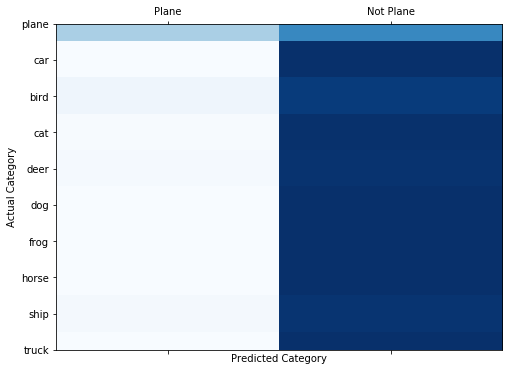

[[ 338  662]
 [   2  998]
 [  44  956]
 [   4  996]
 [  12  988]
 [   0 1000]
 [   1  999]
 [   2  998]
 [  17  983]
 [   2  998]]


In [57]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(2), ['Plane','Not Plane'])
plt.show()
print(confusion_matrix)

Next I'll try using a model with 2 output classes instead of one with 10.

In [58]:
import torch.nn as nn
import torch.nn.functional as F

class BinaryNet(nn.Module):
    def __init__(self):
        super(BinaryNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2) #Changed the output net to only have 2 output nodes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
bnet = BinaryNet()

In [71]:
import torch
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True,
                                        download=True, 
                                        transform=transform)
                                        #target_transform=transforms.Lambda(lambda x: label_to_binary_class(x)))
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=4,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=True, 
                                       transform=transform)
                                       #target_transform=transforms.Lambda(lambda x: label_to_binary_class(x)))
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=4,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [60]:
import torch.optim as optim
import torch
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(bnet.parameters(), lr=0.001, momentum=0.9)

In [72]:
import os

model_directory_path = './model/'
model_path = model_directory_path + 'cifar-10-cnn-binary-model.pt'

if not os.path.exists(model_directory_path):
    os.makedirs(model_directory_path)

if os.path.isfile(model_path):
    # load trained model parameters from disk
    bnet.load_state_dict(torch.load(model_path))
    print('Loaded model parameters from disk.')
else:
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs. labels are binary. 1 or plane, 0 otherwise
            inputs, labels = plane_or_not_plane(data)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = bnet(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    print('Finished Training.')
    torch.save(bnet.state_dict(), model_path)
    print('Saved model parameters to disk.')

[1,  2000] loss: 0.173
[1,  4000] loss: 0.169
[1,  6000] loss: 0.168
[1,  8000] loss: 0.156
[1, 10000] loss: 0.159
[1, 12000] loss: 0.166
[2,  2000] loss: 0.160
[2,  4000] loss: 0.153
[2,  6000] loss: 0.150
[2,  8000] loss: 0.155
[2, 10000] loss: 0.155
[2, 12000] loss: 0.152
Finished Training.
Saved model parameters to disk.


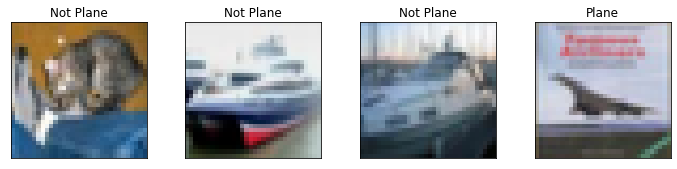

In [73]:
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(testloader)
images, labels = dataiter.next()


fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(binary_class_to_label(labels[idx]))
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [74]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,2], int)
# true and predicted variables for computing the auc score
Y_true = np.zeros(10000)
Y_pred = np.zeros(10000)
index = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, binary_labels = plane_or_not_plane(data)
        outputs = bnet(images)
        
        # take the softmax probability of the binary classifier scores
        softmax_probs = torch.softmax(outputs.data,1)
        
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == binary_labels).sum().item()
        
        y_pred = softmax_probs.data[:,1].tolist()
        y_true = binary_labels.data
        
        Y_pred[index:index+len(y_pred)]=y_pred
        Y_true[index:index+len(y_true)]=y_true
        index += len(y_pred)
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
auc_score = roc_auc_score(Y_true,Y_pred)
print('AUC score on {0} test images: {1:.2f}'.format(total_images, auc_score))
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

AUC score on 10000 test images: 0.95
Model accuracy on 10000 test images: 94.22%


In [75]:
confusion_matrix

array([[625, 375],
       [ 10, 990],
       [ 43, 957],
       [ 11, 989],
       [ 13, 987],
       [  7, 993],
       [  1, 999],
       [  3, 997],
       [ 88, 912],
       [ 27, 973]])

In [76]:
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    accuracy = 0
    if classes[i] == 'plane':
        accuracy = r[0]/np.sum(r)*100
    else:
        accuracy = r[1]/np.sum(r)*100
    print('{0:10s} - {1:.1f}'.format(classes[i], accuracy))

Category   - Accuracy
plane      - 62.5
car        - 99.0
bird       - 95.7
cat        - 98.9
deer       - 98.7
dog        - 99.3
frog       - 99.9
horse      - 99.7
ship       - 91.2
truck      - 97.3


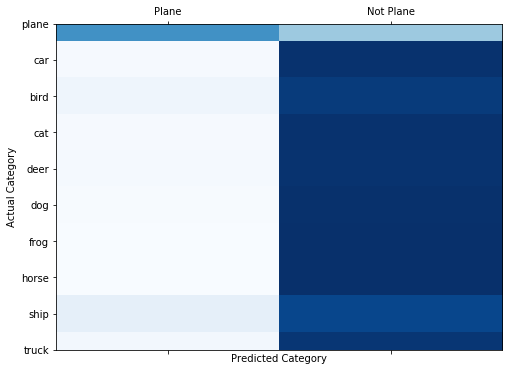

In [78]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(2), ['Plane','Not Plane'])
plt.show()

### Problem 3: Adversarial attacks: Horses and Cars.

Consider the first CNN model that you trained in the previous problem. Take an image $x_1$ of
a horse that is classified correctly as a horse. It is possible to modify the input pixels very little
(say 5-10 percent)) and fool the model that this image is a car. For the target attack class (Car in
this example), compute the gradient of the class logit with respect to the input pixels. Modify the
image in this gradient direction, while keeping each pixel to be perturbed by 0.1 (since each pixel
$1 \in [-1,1]$) from the original horse image x. Create and show 8 adversarial perturbed horse images
you created that are classified as cars.

Followed some of https://savan77.github.io/blog/imagenet_adv_examples.html for this assignment

In [10]:
import os

net = Net()

model_directory_path = './model/'
model_path = model_directory_path + 'cifar-10-cnn-model.pt'

if not os.path.exists(model_directory_path):
    os.makedirs(model_directory_path)

if os.path.isfile(model_path):
    # load trained model parameters from disk
    net.load_state_dict(torch.load(model_path))
    print('Loaded model parameters from disk.')
else:
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    print('Finished Training.')
    torch.save(net.state_dict(), model_path)
    print('Saved model parameters to disk.')

Loaded model parameters from disk.


In [11]:
import torch
import torch.nn
from torch.autograd.gradcheck import zero_gradients
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image
from torchvision import transforms
import numpy as np
import requests, io
import matplotlib.pyplot as plt
from torch.autograd import Variable
%matplotlib inline

In [12]:
def load_img(url):
    response = requests.get(url)
    img = Image.open(io.BytesIO(response.content))
    return img

In [13]:

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# prepocess the images into the size the CNN expects
preprocess = transforms.Compose([
                transforms.Resize((32,32)),  
                transforms.ToTensor(),
                transforms.Normalize(mean, std)])

In [14]:
url = 'https://images2.minutemediacdn.com/image/upload/c_crop,h_1194,w_2121,x_0,y_34/f_auto,q_auto,w_1100/v1553786510/shape/mentalfloss/539787-istock-879570436.jpg'
img = load_img(url)
image_tensor = preprocess(img) #preprocess an i
image_tensor = image_tensor.unsqueeze(0) # add batch dimension.  C X H X W ==> B X C X H X W

In [15]:
img_variable = Variable(image_tensor, requires_grad=True) #convert tensor into a variable

In [20]:
# next classify the image
output = net.forward(img_variable)
label = (torch.max(output.data, 1)[1][0]).item()    #get an index(class number) of a largest element
print("The CNN classifies the image as a {}".format(classes[label]))

The CNN classifies the image as a horse


Now try to modify the image to the target class using the Fast Gradient Sign Method.

Let's say we have an input X, which is correctly classified by our model (M). We want to find an adversarial example  $X' $ , which is perceptually indistinguishable from original input $X$, such that it will be misclassified by that same model ($M$). We can do that by adding an adversarial perturbation (  $θ$  ) to the original input. Note that we want adversarial example to be indistinguishable from the original one. That can be achieved by constraining the magnitude of adversarial perturbation:  $||X−X'||_∞ ⩽ ϵ $ . That is, the  $L_∞$ norm should be less than epsilon. Here,  $L_∞$  denotes the maximum changes for all pixels in adversarial example. Fast Gradient Sign Method (FGSM) is a fast and computationally efficient method to generate adversarial examples. However, it usually has a lower success rate. The formula to find adversarial example is as follows:
$X_{adv}=X + ϵ sign(∇_XJ(X,Y_{true})$
 
Here,
$X$ = original (clean) input
$Xadv$  = adversarial input (intentionally designed to be misclassified by our model)
$ϵ$  = magnitude of adversarial perturbation
$∇_XJ(X,Y_{true})$  = gradient of loss function w.r.t to input (X)

In [21]:
y_true = classes.index('car')
target = Variable(torch.LongTensor([y_true]), requires_grad=False)

In [22]:
#perform a backward pass in order to get gradients
loss = torch.nn.CrossEntropyLoss()
loss_cal = loss(output, target)
loss_cal.backward(retain_graph=True)    #this will calculate gradient of each variable (with requires_grad=True) and can be accessed by "var.grad.data"

Following code cell computes the adversarial example using formula shown above.

In [23]:
eps = 0.02
x_grad = torch.sign(img_variable.grad.data)                #calculate the sign of gradient of the loss func (with respect to input X) (adv)
x_adversarial = img_variable.data + eps * x_grad          #find adv example using formula shown above
output_adv = net.forward(Variable(x_adversarial))   #perform a forward pass on adv example
x_adv_pred = labels[torch.max(output_adv.data, 1)[1][0]]    #classify the adv example
op_adv_probs = F.softmax(output_adv, dim=1)                 #get probability distribution over classes
adv_pred_prob =  round((torch.max(op_adv_probs.data, 1)[0][0]) * 100, 4)      #find probability (confidence) of a predicted class

NameError: name 'labels' is not defined

### Problem 4: Experimenting with Fast.AI (Extra credit 20 points).

1. Create an account on paperspace or a cloud service of your choice. You should make sure
that you are able to install all the libraries and tools needed for Fast.ai. If you choose to do
this on paperspace.com, then:

(a) Create an account on paperspace.

(b) Log in. 

(c) Go to Gradient in the toolbar in the left. 

(d) Create Notebook. 

(e) Paperspace Fast.AI 1.0 (V3). 

(f) Choose the P5000 machine ($0.78/hour). 

(g) Launch, and go to: course-v3 −→ nbs −→ dl1 and open up the first lesson: lesson1-pets.ipynb.

2. Fast.ai
Fast.ai has created a large library of tools that make setting up and training a neural network
very easy, especially through the use of transfer learning. The notebook you opened in the
previous exercise corresponds to the first lesson under “Practical Deep Learning for Coders.”
Watch this lesson, and follow along on the notebook.

3. Make sure you understand the key elements of using Fast.ai, including understanding how to
access the help documentation. Specifically:
(a) Figure out: ImageDataBunch: this is the main data structure that is used.
(b) Figure out: create cnn. This is the way you will create a “learner” that you will then
train for some number of epochs. The key here is how easy it is to download a pre-set
architecture (e.g., the notebook starts with resnet34, but has various others as well).

4. Explain what is a residual network, and the basic motivation for using it. Also explain what
are the main elements of resnet34 and resnet50. How many layers, how many neurons total,
how many weights; and then anything else you want to say.

5. Transfer learning using Fast.ai and create cnn: Please explain how pretrained resnet34 is
modified to get the network that the notebook ultimately trains (i.e., explain what are the
last layers that are added).

6. Download a NOT pre-trained resnet34, and then by playing with the number of epochs and
learning rates (possibly different learning rates across layers), see how low you can get the
error. Can you get below 20%?

7. And for the main part of this HW: download (and label) your own data set of your choie,
create a classification problem, and then use the main tools/ideas of this notebook to build a
classifier. It does not need to be a multi-label classifier.
For getting data, you may want to refer to the discussion here, for various tools that could be
useful: https://forums.fast.ai/t/tips-for-building-large-image-datasets/26688/
36.

### Submission:
I completed this part of the homework in paperspace and will submit it as a different jupyter notebook in the submission. The notebook is javier_palomares_hw2_problem4

### Problem 5: Final project proposal.
Recall: the final project presentations will be on the last day of class, Saturday Dec 14th 1-5pm.
Final Project presentations are on Dec 14th in class. Final project reports due December 15th
midnight. Presentation duration: 10 minute presentations plus questions. The last problem of
this homework is to write your project proposal (1-2 pages). Please include team members, what
dataset you plan to use, what questions you plan to ask. Some preliminary results that show you
have started experimenting with the data and show promise. One interesting direction is you plan
to combine different datasets or search for dataset search engines for numerous resources. You will
be graded on the project proposal.

PDF of project proposal is attached as a pdf in this repo